## Packages

In [2]:
from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")

## Editable Variables

In [3]:
## Dataset folder relative path, defaults to "Datasets"
DATASET = Path("datasets")

### GRAD CAM
NUM_FILES = 5

## Static Variables

In [4]:
### Dataloader
BATCH_SIZE = 64
VAL_BATCH_SIZE = 128
TEST_PERCENTAGE = .2
RANDOM_SEED = 3407
RESIZE = 224
AUG_TRANSFORM_SIZE = 224
AUG_TRANSFORM_MINSCALE = .75

### Model
MODEL, MODEL_NAME = resnet50, "RESNET50"
FREEZE_EPOCHS = 2
UNFREEZE_EPOCH = 10

In [5]:
np.random.seed(RANDOM_SEED);
torch.manual_seed(RANDOM_SEED);

## Number of Files in Folders

In [6]:
folders = [folder for folder in DATASET.iterdir() if folder.is_dir()]

for folder in folders:
    print(f"\n\033[1m{folder} folder contains {len(get_image_files(folder))} files\033[0m")


datasets/Negative folder contains 495 files

datasets/Positive folder contains 495 files


## Datablock & Model

### Datablock

In [7]:
labels = []
for folder in folders:
    labels += [folder.name] * len(get_image_files(folder))

In [8]:
dls = DataBlock(
          blocks = (ImageBlock, CategoryBlock),
          get_items = get_image_files,
          get_y = parent_label,
          splitter = TrainTestSplitter(test_size=TEST_PERCENTAGE, random_state=RANDOM_SEED, stratify=labels),
          item_tfms = Resize(RESIZE),
          batch_tfms = aug_transforms(size=AUG_TRANSFORM_SIZE, min_scale=AUG_TRANSFORM_MINSCALE)
        ).dataloaders(DATASET, bs=BATCH_SIZE, val_bs = VAL_BATCH_SIZE)

Training Dataset Sample


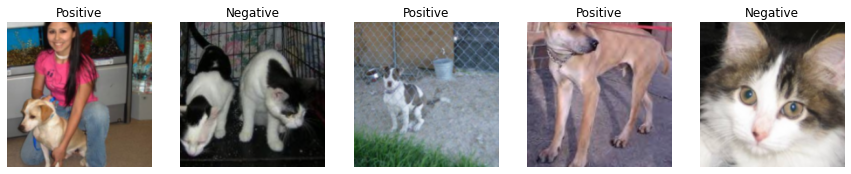

In [9]:
print("Training Dataset Sample")
dls.train.show_batch(max_n = 5, nrows=1, unique=False)

Validating Dataset Sample


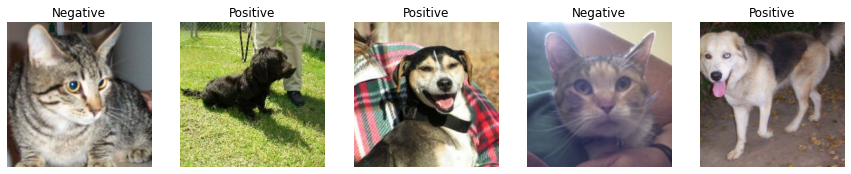

In [10]:
print("Validating Dataset Sample")
dls.valid.show_batch(max_n = 5, nrows = 1)

In [11]:
train_ds = torch.stack([c[1] for c in dls.train_ds])
valid_ds = torch.stack([c[1] for c in dls.valid_ds])

In [12]:
print(f"""\nTrain set 
Total Images - \033[1m{len(train_ds)}\033[0m, 
{dls.vocab[0]} images - \033[1m{len(train_ds[train_ds == 1])}\033[0m
{dls.vocab[1]} images - \033[1m{len(train_ds[train_ds == 0])}\033[0m
""")


print(f"""\nTest set 
Total Images - \033[1m{len(valid_ds)}\033[0m, 
{dls.vocab[0]} images - \033[1m{len(valid_ds[valid_ds == 1])}\033[0m
{dls.vocab[1]} images - \033[1m{len(valid_ds[valid_ds == 0])}\033[0m
""")


Train set 
Total Images - 792, 
Negative images - 396
Positive images - 396


Test set 
Total Images - 198, 
Negative images - 99
Positive images - 99



### Model

In [13]:
print(f"Model: {MODEL_NAME}")
learn = vision_learner(dls, 
                       MODEL, 
                       metrics = [accuracy, F1Score()], 
                       cbs = EarlyStoppingCallback(patience=4, min_delta=0.1,)
                       )

Model: RESNET50


## Training

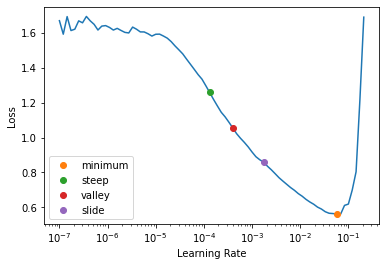

In [14]:
## Learning rate finder

lr_value = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide]);

In [15]:
## Training

learn.fit_one_cycle(FREEZE_EPOCHS, lr_value.slide)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.534217,0.088122,0.979798,0.979592,00:07
1,0.300722,0.072442,0.984848,0.984925,00:06


In [15]:
learn.unfreeze()

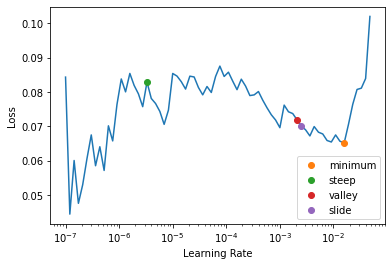

In [16]:
lr_value = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide]);

In [17]:
learn.fit_one_cycle(UNFREEZE_EPOCH, lr_value.valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.071177,0.074706,0.989899,0.990000,00:05
1,0.063048,0.084109,0.979798,0.980000,00:05
2,0.056082,0.118794,0.979798,0.980000,00:05
3,0.065139,0.151117,0.959596,0.960396,00:05
4,0.064568,0.107319,0.974747,0.974874,00:06


No improvement since epoch 0: early stopping


## Test & Visualize

### Testing

In [18]:
scores = learn.validate()
print(f"Valid Loss: {scores[0]},\nAccuracy: {scores[1]},\nF1-Score: {scores[2]}")

Valid Loss: 0.10731858015060425,
Accuracy: 0.9747474789619446,
F1-Score: 0.9748743718592964


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

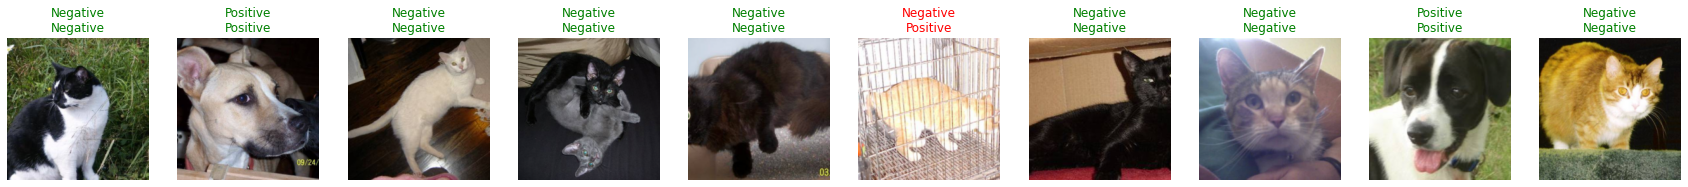

In [21]:
learn.show_results(nrows=1, max_n=10)

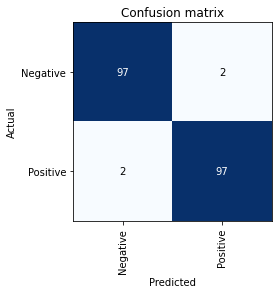

In [22]:
interp.plot_confusion_matrix()

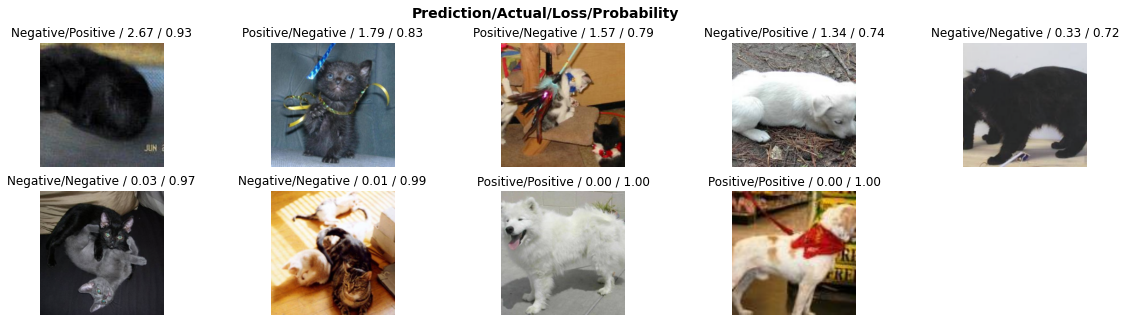

In [23]:
losses = interp.plot_top_losses(10, nrows = 2, figsize=(20, 5))

In [24]:
_, top_losses = interp.top_losses()
logits, actual, predicted = learn.get_preds(with_decoded=True)

In [25]:
top_confused_predictions = list(zip(dls.valid_ds[top_losses[:NUM_FILES]],
                               actual[top_losses[:NUM_FILES]],
                               predicted[top_losses[:NUM_FILES]]))

top_correct_predictions = list(zip(dls.valid_ds[top_losses[-NUM_FILES:]],
                              actual[top_losses[-NUM_FILES:]],
                              predicted[top_losses[-NUM_FILES:]]))

### Visualize GRAD-CAM

In [26]:
classes = {count: name for count, name in enumerate(dls.vocab)}
print("Prediction Classes: ", classes)

Prediction Classes:  {0: 'Negative', 1: 'Positive'}


In [27]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [28]:
def cal_cam_map(x, cls):
    with HookBwd(learn.model[0]) as hookg:
        with Hook(learn.model[0]) as hook:
            output = learn.model.eval()(x.cuda())
            act = hook.stored
        output[0, cls].backward()
        grad = hookg.stored
        
    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    return cam_map


def show_grad_cam(data: list, prediction_heading: str):
    print("\n"+prediction_heading+'\n')
    fig, axs = plt.subplots(1, NUM_FILES, figsize = (15, 15))
    for (image, act, pred), ax in zip(data, axs):
        prep = dls.test_dl([image[0]])
        x, = prep.one_batch()
        x_dec = dls.train.decode((x,))[0][0]
        cam_map = cal_cam_map(x, cls=act)
        act, pred = classes[int(act)], classes[int(pred)]
        ax.set_title(f"Actual = {act}\nPredicted = {pred}")
        x_dec.show(ctx = ax)
        ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,224,224,0),
              interpolation='bilinear', cmap='inferno');
    plt.tight_layout()


Top Correct Predictions



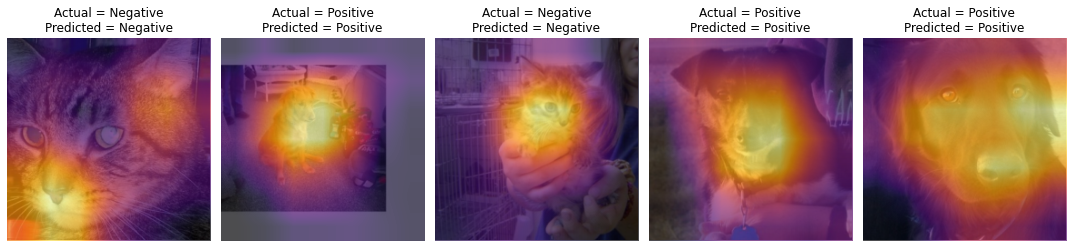

In [29]:
show_grad_cam(top_correct_predictions, "Top Correct Predictions")


Top Confused Predictions



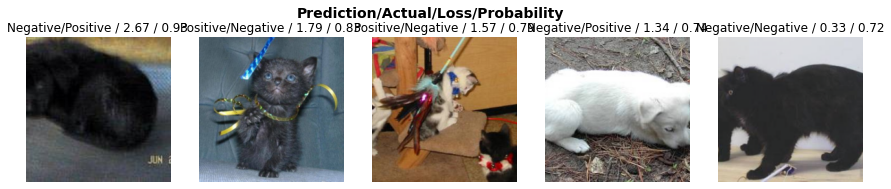

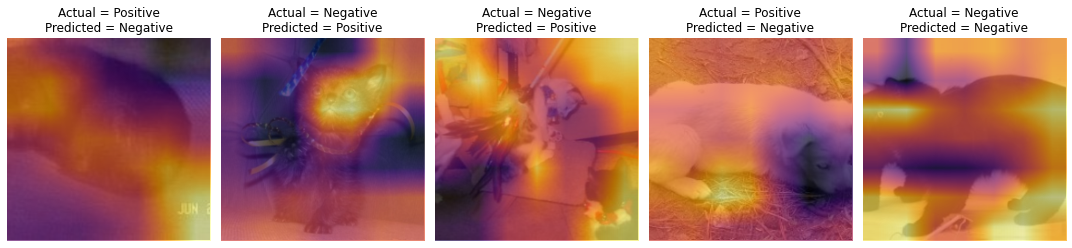

In [30]:
interp.plot_top_losses(NUM_FILES, nrows = 1)
show_grad_cam(top_confused_predictions, "Top Confused Predictions")

## Save Model & Logs

In [31]:
def save_model(path: Path):
    # Export the content of `self` without the items and the optimizer state for inference
    learn.export(path)
    print(f"""
    Model Saved  ✅
    Folder Name: \033[1m{MODEL_PATH} \033[0m
    File Name:   \033[1m{MODEL_FILENAME}\033[0m""", end='\n')

In [33]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True)

DATETIME = datetime.now().strftime("%w-%m-%Y-%H:%M:%p")

MODEL_FILENAME = f"CP-Classifier({DATETIME}).pkl"

logs = {
            "DATE TIME"     : DATETIME,
            "MODEL FILENAME": MODEL_FILENAME,
            "MODEL NAME"    : MODEL_NAME,
            }

In [34]:
save_model(MODEL_PATH/MODEL_FILENAME)


    Model Saved  ✅
    Folder Name: models 
    File Name:   CP-Classifier(4-06-2022-11:26:AM).pkl
